# Importing Libs

In [1]:
# metrics
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    r2_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    average_precision_score,
    roc_auc_score,
    brier_score_loss
)
from sklearn.model_selection import (
    TimeSeriesSplit
)
import sklearn

import optuna

# TA tools
import ta

# basic
import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

from tqdm.notebook import tqdm

import logging, time
from typing import Callable, Optional

# options
pd.set_option('display.max_columns', None)
from dataclasses import dataclass

# versions used
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"sklearn=={sklearn.__version__}")
print(f"optuna=={optuna.__version__}")

pandas==2.2.3
numpy==2.2.4
sklearn==1.6.1
optuna==4.4.0


# Data

We have loaded data in a `stock_loader_experiments.ipynb` notebook  using our cctx library.

In [2]:
# let's take Gazprom stocks data
df_base = pd.read_parquet('data/raw_data/BTC_USD_since_2025_03_01.parquet')

# converting and deleting some columns
df_base['ts'] = pd.to_datetime(df_base['ts'])

df_base.sample(1)

,ts,Open,High,Low,Close,Volume
104989,2025-05-12 21:49:00+00:00,102457.25,102457.26,102447.6,102447.61,6.05389


There may be problem with consistency in data (i.e. some minutes are missed), so let's check it

In [3]:
def check_minute_difference(datetime1, datetime2):
  difference = datetime1 - datetime2
  return difference.total_seconds() == 60.0

In [4]:
for i in range(df_base.shape[0]):
    if i == df_base.shape[0] - 1:
        break
    if not check_minute_difference(df_base['ts'].iloc[i+1], df_base['ts'].iloc[i]):
        print(i)

Checking time-series data

In [5]:
def ensure_ohlcv(df: pd.DataFrame,
                 time_col: str = 'ts',
                 tz: str | None = None) -> pd.DataFrame:
    cols = {c.lower(): c for c in df.columns}
    required = [time_col,'open','open','low','close','volume']
    missing = [c for c in required if c not in cols]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    df['ts'] = pd.to_datetime(df['ts'], utc=True, errors='coerce')
    df = df.dropna(subset=['ts']).sort_values('ts').drop_duplicates('ts')
    df = df.set_index('ts')
    if tz:
        if df.index.tz is None:
            df.index = df.index.tz_localize('UTC')
        df.index = df.index.tz_convert(tz)
    return df

In [6]:
df = ensure_ohlcv(df_base); del df_base

## Features

Let's add indicators that can be used by several approaches to enhance its results

### Classical indicators

In [7]:
def add_basic_feats(df):
    df = df.copy()
    df['HL_range'] = (df['High'] - df['Low']) / df['Close']
    df['log_vol'] = np.log1p(df['Volume'])
    return df

df = add_basic_feats(df)

#### SMA & EMA

Moving Averages (SMA & EMA): The Simple Moving Average (SMA) and Exponential Moving Average (EMA) smooth out price data to reveal the underlying trend. They are fundamental trend-following indicators. Intraday traders often plot short-term moving averages (e.g. 5-minute or 15-minute SMA) to identify trend direction. A common strategy is the moving average crossover – for example, if a short-term EMA crosses above a longer-term EMA, it generates a buy signal (anticipating upward momentum). These crossovers have been used on MOEX stocks to catch emerging trends. In one study, various SMA lengths were tested in an intraday RSI strategy; shorter-period SMAs improved profitability during downtrends, indicating the importance of choosing an appropriate moving average length for the market condition. Overall, moving averages help traders filter out noise and decide if momentum favors long or short positions. They are also components of other indicators (for instance, the MACD uses EMA calculations).

In [8]:
df['SMA_9'] = ta.trend.sma_indicator(df['Close'], 9)
df['SMA_10'] = ta.trend.sma_indicator(df['Close'], 10)
df['SMA_21'] = ta.trend.sma_indicator(df['Close'], 21)

df['EMA_9'] = ta.trend.ema_indicator(df['Close'], 9)
df['EMA_10'] = ta.trend.ema_indicator(df['Close'], 10)
df['EMA_21'] = ta.trend.ema_indicator(df['Close'], 21)

#### RSI

Relative Strength Index (RSI): RSI is a popular momentum oscillator that measures the magnitude of recent price gains vs. losses on a 0–100 scale. It is used to identify overbought conditions (RSI above 70, indicating prices may have risen too fast) and oversold conditions (RSI below 10). RSI has shown its value in many markets; for example, studies on emerging markets found that RSI signals can generate accurate buy/sell prompts and even produce abnormal returns. Traders often use RSI on intraday MOEX charts to anticipate reversals – if a stock’s RSI dips below 10, it may be poised for a bounce (buy signal), whereas an RSI above 70 could warn of an upcoming pullback (sell signal). Importantly, combining RSI with other indicators strengthens its effectiveness. Research suggests the best results come from using RSI alongside complementary signals like moving averages ￼, which confirm the trend context. For instance, if the RSI gives an oversold reading and at the same time the price is bouncing off a key moving average support, the confluence increases confidence in a buy trade. This indicator’s ubiquity among traders makes it a self-fulfilling tool at times – many MOEX trading algorithms monitor RSI levels, contributing to short-term support and resistance around those threshold values.

In [9]:
df['RSI_9'] = ta.momentum.rsi(df['Close'], 9)
df['RSI_11'] = ta.momentum.rsi(df['Close'], 11)
df['RSI_14'] = ta.momentum.rsi(df['Close'], 14)
df['RSI_30'] = ta.momentum.rsi(df['Close'], 30)

#### MACD

Moving Average Convergence Divergence (MACD): MACD is another momentum/trend indicator that calculates the difference between two EMAs and a signal line (the EMA of that difference). It oscillates above and below zero, highlighting changes in trend momentum. A positive MACD indicates upward momentum, while a negative MACD indicates downward momentum; the crossing of MACD above its signal line is a classic bullish signal (and vice versa for bearish). MACD is widely favored for intraday trading because it combines aspects of trend following and momentum in one indicator. Traders on the MOEX use MACD histograms and crossovers to spot trend reversals or trend strength changes in stocks or the MOEX index itself. A strong use case is pairing MACD with RSI: one popular strategy requires MACD line crossing above the signal and RSI coming out of oversold territory to trigger a buy, capturing both trend and momentum confirmation. In fact, backtests of strategies combining MACD and RSI have shown high success rates – one such strategy yielded about a 73% win rate over hundreds of trades, with an average 0.88% gain per trade. This demonstrates how MACD, especially in combination with RSI, can be a powerful tool for timing intraday entries and exits.

In [10]:
df

,Open,High,Low,Close,Volume,HL_range,log_vol,SMA_9,SMA_10,SMA_21,EMA_9,EMA_10,EMA_21,RSI_9,RSI_11,RSI_14,RSI_30
ts,,,,,,,,,,,,,,,,,
2025-03-01 00:00:00+00:00,84349.95,84390.05,84324.42,84338.54,14.42832,7.781733e-04,2.736205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:01:00+00:00,84337.70,84337.70,84269.50,84274.88,9.99548,8.092566e-04,2.397484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:02:00+00:00,84274.88,84282.60,84266.01,84266.02,5.58371,1.968765e-04,1.884598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:03:00+00:00,84266.01,84300.00,84257.15,84299.99,4.66581,5.083037e-04,1.734450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-01 00:04:00+00:00,84299.99,84346.10,84295.74,84295.75,5.14888,5.974204e-04,1.816270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-16 18:48:00+00:00,117699.99,117700.00,117699.99,117699.99,0.30569,8.496177e-08,0.266732,117677.673333,117678.474,117686.643333,117683.140376,117683.146412,117686.587855,60.413835,57.810797,55.254197,50.990567
2025-08-16 18:49:00+00:00,117700.00,117700.00,117699.99,117699.99,0.71471,8.496177e-08,0.539244,117679.894444,117679.905,117686.857619,117686.510301,117686.208883,117687.806232,60.413835,57.810797,55.254197,50.990567
2025-08-16 18:50:00+00:00,117699.99,117700.00,117699.99,117699.99,0.60947,8.496177e-08,0.475905,117682.115556,117681.904,117687.071905,117689.206241,117688.714541,117688.913847,60.413835,57.810797,55.254197,50.990567


In [11]:
# the best parameters for intraday trading mentioned here -> https://market-bulls.com/macd-indicator-trading-strategies/
macd = ta.trend.MACD(
    close=df['Close'],
    window_slow=17,
    window_fast=8,
    window_sign=9
)

df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Hist'] = macd.macd_diff()

#### Bollinger Bands

Bollinger Bands: Bollinger Bands are a volatility indicator consisting of a moving average (typically 20-period SMA) and upper/lower bands set a certain number of standard deviations away (often 2σ). The bands widen when volatility increases and contract when volatility drops. Intraday traders use Bollinger Bands to identify potential breakouts or mean-reversion opportunities. For example, when price repeatedly touches the upper band, the market may be overextended to the upside (potential reversal or short setup), whereas a sharp move outside the bands could signal an emerging breakout with increased volatility. In high-frequency trading contexts, Bollinger Bands help gauge if current price swings are outside normal volatility ranges. On the MOEX, which can experience sudden moves due to news or low liquidity in certain stocks, Bollinger Band signals are quite useful. A common strategy is to fade extreme moves – if a Russian stock’s price spikes well above the upper band on an intraday chart, traders might short expecting a pullback toward the mean. Conversely, touching the lower band after a steady decline could present a buy-the-dip opportunity. However, it’s important to confirm with other indicators (Bollinger Band breakouts combined with volume spikes or momentum divergences provide stronger evidence of a true breakout or reversal).

In [12]:
# the best parameters for intraday trading mentioned here -> https://www.stockdaddy.in/blog/bollinger-bands-strategy
bb = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)

df['BB_mband_20_2'] = bb.bollinger_mavg()
df['BB_hband_20_2'] = bb.bollinger_hband()
df['BB_lband_20_2'] = bb.bollinger_lband()
df['BB_width_20_2'] = bb.bollinger_wband()
df['BB_pband_20_2'] = bb.bollinger_pband()
df['BB_hband_ind_20_2'] = bb.bollinger_hband_indicator()
df['BB_lband_ind_20_2'] = bb.bollinger_lband_indicator()

#### OBV

On-Balance Volume (OBV) and Volume Indicators: Volume-based indicators play a crucial role in validating price movements. OBV is a simple yet powerful indicator that accumulates volume, adding volume on up days and subtracting on down days. It effectively measures buying and selling pressure. Rising OBV indicates that volume is flowing into an asset (buyers are dominant), often foreshadowing an upward breakout, while falling OBV signals distribution (selling pressure). Traders use OBV intraday to confirm trends: if price is climbing and OBV is also steadily rising, it suggests the uptrend is backed by strong volume (and likely to continue). If price makes new highs but OBV fails to reach a new high (a bearish divergence), it can warn that the rally is losing support and may reverse. On MOEX, where certain stocks can have erratic volume, OBV helps filter false price moves. For instance, a sudden price jump on low volume is treated suspiciously by algo-traders – if OBV doesn’t confirm the move, they may avoid the bait. Other volume indicators like the Volume Weighted Average Price (VWAP) are also popular intraday tools (VWAP is often used by institutional traders as a benchmark; prices above VWAP indicate an uptrend with strength, below VWAP indicates a downtrend). In general, volume indicators complement price-based indicators by adding the dimension of market participation, which is key in the relatively smaller and sometimes volatile Russian market. Combining volume signals with price signals is a widely recommended practice – for example, a breakout above a resistance level is far more convincing if accompanied by a surge in OBV or volume, confirming that big players are driving the move.

In [13]:
obv = ta.volume.OnBalanceVolumeIndicator(
    close=df['Close'],
    volume=df['Volume']
)

df['OBV'] = obv.on_balance_volume()

####  Stochastic oscilator

The Stochastic Oscillator (similar to RSI, used to indicate overbought/oversold levels based on recent closing prices relative to price range) is often used on short time frames for MOEX stocks to pick turning points.

In [14]:
stoch = ta.momentum.StochasticOscillator(
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    window=9,
    smooth_window=3
)

df['Stoch_K'] = stoch.stoch()
df['Stoch_D'] = stoch.stoch_signal()

#### Commodity Channel Index

The Commodity Channel Index (CCI) is another momentum indicator highlighted in studies for trend detection.

In [15]:
cci = ta.trend.CCIIndicator(
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    window=14,
    constant=0.010 # more sensitive
)

df['CCI'] = cci.cci()

#### Average True Range

Average True Range (ATR) is commonly monitored to gauge intraday volatility – for example, a widening ATR on a stock like Sberbank might imply the next price swing could be larger than usual, prompting traders to adjust stop-loss distances.

In [16]:
atr = ta.volatility.AverageTrueRange(
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    window=9
)

df['ATR_9'] = atr.average_true_range()

#### Ichimoku Cloud

Ichimoku Cloud (a comprehensive trend system) is sometimes applied to index futures or highly liquid Russian equities to map support/resistance and trend momentum at a glance.

In [17]:
ichimoku = ta.trend.IchimokuIndicator(
    high=df['High'],
    low=df['Low'],
    window1=9,
    window2=18,
    window3=34,
    visual=False
)

df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()
df['Ichimoku_Base'] = ichimoku.ichimoku_base_line()
df['Ichimoku_Conversion'] = ichimoku.ichimoku_conversion_line()

### HFT indicators

In [18]:
def _rolling_z(x: pd.Series, w: int) -> pd.Series:
    m = x.rolling(w).mean()
    s = x.rolling(w).std(ddof=0)
    return (x - m) / s

def _safe_div(a: pd.Series, b: pd.Series) -> pd.Series:
    out = pd.Series(np.nan, index=a.index, dtype='float64')
    mask = (b != 0) & (~b.isna())
    out.loc[mask] = a.loc[mask] / b.loc[mask]
    return out

def add_microstructure_feats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Strict: leaves NaNs during warmup; do NOT fill. Slice before backtest.
    Requires: columns Open, High, Low, Close, Volume; tz-aware index is fine.
    """
    out = df.copy()

    # signed volume (tick-rule via bar): sign(C-O) * Volume
    sgn = np.sign(out['Close'] - out['Open'])
    sgn.replace(0, np.nan, inplace=True)  # strict: ambiguous tick sign => NaN
    out['signed_vol'] = sgn * out['Volume']

    # OFI proxy (bar): ((C-O)/(H-L)) * Volume  (Easley-style, bar-level)
    out['ofi_proxy'] = _safe_div(out['Close'] - out['Open'], out['High'] - out['Low']) * out['Volume']

    # VWAP per UTC day
    day = pd.Series(out.index.date, index=out.index)
    pv = out['Close'] * out['Volume']
    out['vwap'] = _safe_div(pv.groupby(day).cumsum(), out['Volume'].groupby(day).cumsum())
    out['vwap_dev'] = out['Close'] - out['vwap']

    # z-scores (200-bar context window)
    out['v_z']   = _rolling_z(out['Volume'], 200)
    out['ofi_z'] = _rolling_z(out['ofi_proxy'], 200)
    out['vwap_dev_z'] = _rolling_z(out['vwap_dev'], 200)

    # Bollinger width (20,2) if not present
    if 'BB_width_20_2' in out.columns:
        out['bbw'] = out['BB_width_20_2']
    else:
        mid = out['Close'].rolling(20).mean()
        std = out['Close'].rolling(20).std(ddof=0)
        out['bbw'] = _safe_div(2*2.0*std, mid)

    # high-TF trend filter
    if 'EMA_200' not in out.columns:
        out['EMA_200'] = ta.trend.ema_indicator(out['Close'], 200)

    # realized vol proxy (for adaptive TP/SL)
    out['ret1'] = out['Close'].pct_change()
    out['rv_std'] = out['ret1'].rolling(60).std(ddof=0)  # ~1h for 1-min bars

    return out

df = add_microstructure_feats(df)

### Summing up

In [19]:
df.dropna(inplace=True)

In [20]:
indicators = df.columns[df.columns.str.contains('SMA|EMA|RSI|MACD|BB|Stoch|CCI|ATR|Ichimoku|OBV|Volume|Open|Close|High|Low')]

In [21]:
df

,Open,High,Low,Close,Volume,HL_range,log_vol,SMA_9,SMA_10,SMA_21,EMA_9,EMA_10,EMA_21,RSI_9,RSI_11,RSI_14,RSI_30,MACD,MACD_Signal,MACD_Hist,BB_mband_20_2,BB_hband_20_2,BB_lband_20_2,BB_width_20_2,BB_pband_20_2,BB_hband_ind_20_2,BB_lband_ind_20_2,OBV,Stoch_K,Stoch_D,CCI,ATR_9,Ichimoku_A,Ichimoku_B,Ichimoku_Base,Ichimoku_Conversion,signed_vol,ofi_proxy,vwap,vwap_dev,v_z,ofi_z,vwap_dev_z,bbw,EMA_200,ret1,rv_std
ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-03-01 03:19:00+00:00,84987.81,85008.03,84970.37,84986.70,10.42045,4.431282e-04,2.435406,85038.594444,85038.817,85118.582381,85035.162460,85041.470078,85105.270620,35.455139,36.896208,39.082896,47.100358,-56.232998,-57.325576,1.092578,85112.4885,85339.945506,84885.031494,0.534486,0.223490,0.0,0.0,539.292660,9.124944,12.593129,-197.000066,74.390850,85115.2675,85324.240,85170.685,85059.850,-10.42045,-0.307135,84732.026713,254.673287,-0.475998,-0.084242,0.207212,0.534486,84704.440948,-0.000013,0.000891
2025-03-01 03:20:00+00:00,84986.70,85009.44,84986.70,84992.79,9.18897,2.675521e-04,2.321306,85031.503333,85034.014,85106.788571,85026.687968,85032.619154,85095.045109,36.594715,37.734346,39.664282,47.297611,-54.012193,-56.662900,2.650707,85100.2780,85325.899869,84874.656131,0.530249,0.261796,0.0,0.0,548.481630,12.527939,7.281477,-156.644161,68.651866,85115.2675,85324.240,85170.685,85059.850,9.18897,2.460898,84732.560369,260.229631,-0.523643,0.033921,0.219606,0.530249,84707.310093,0.000072,0.000890
2025-03-01 03:21:00+00:00,84992.78,85070.54,84992.78,85020.00,11.08671,9.146083e-04,2.492107,85021.613333,85030.353,85096.455238,85025.350374,85030.324763,85088.222826,41.762975,41.549833,42.313371,48.190534,-48.119853,-54.954290,6.834437,85086.7785,85297.175897,84876.381103,0.494548,0.341304,0.0,0.0,559.568340,27.732454,16.461779,-31.246039,69.663881,85115.2675,85324.240,85170.685,85059.850,11.08671,3.880919,84733.268359,286.731641,-0.448560,0.092322,0.291610,0.494548,84710.421435,0.000320,0.000882
2025-03-01 03:22:00+00:00,85020.01,85020.01,84982.01,84982.01,20.32063,4.471535e-04,3.059675,85014.060000,85017.653,85081.789524,85016.682299,85021.540260,85078.567115,37.022925,37.975926,39.693008,47.039442,-47.079103,-53.379253,6.300150,85072.6295,85270.896259,84874.362741,0.466112,0.271471,0.0,0.0,539.247710,10.066592,16.775662,-147.390891,66.145672,85089.9100,85324.240,85151.635,85028.185,-20.32063,-20.320630,84734.386270,247.623730,-0.084932,-0.945010,0.174761,0.466112,84713.123809,-0.000447,0.000881
2025-03-01 03:23:00+00:00,84982.01,85009.44,84961.44,84985.05,17.58164,5.648052e-04,2.922174,85008.610000,85011.159,85068.459048,85010.355840,85014.905668,85070.065559,37.659891,38.442001,40.013140,47.143955,-44.859348,-51.675272,6.815924,85056.4190,85225.516078,84887.321922,0.397612,0.288970,0.0,0.0,556.829350,18.954721,18.917922,-163.890267,64.129486,85058.2525,85319.775,85092.785,85023.720,17.58164,1.113504,84735.357198,249.692802,-0.196603,-0.022613,0.177206,0.397612,84715.829542,0.000036,0.000874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-16 18:45:00+00:00,117661.56,117661.56,117629.94,117649.79,14.88361,2.687638e-04,2.765288,117678.661111,117680.540,117687.347143,117674.148078,117675.519389,117684.978745,16.048620,21.233508,27.143261,39.527992,-9.741601,-5.593031,-4.148570,117686.9400,117712.558919,117661.321081,0.043537,-0.225050,0.0,1.0,36086.153754,29.398697,9.813460,-351.153518,8.208387,117664.3350,117693.500,117664.970,117663.700,-14.88361,-5.540167,117584.199471,65.590529,2.335666,-1.068700,-1.798977,0.043537,117702.293223,-0.000100,0.000124
2025-08-16 18:46:00+00:00,117649.79,117671.72,117649.79,117671.72,1.21484,1.863659e-04,0.795180,117675.802222,117677.967,117686.215238,117673.662463,117674.828591,117683.773404,42.396244,42.021718,42.316890,45.036790,-8.757504,-6.225926,-2.531578,117685.7510,117711.872813,117659.6291

In [22]:
indicators

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_9', 'SMA_10', 'SMA_21',
       'EMA_9', 'EMA_10', 'EMA_21', 'RSI_9', 'RSI_11', 'RSI_14', 'RSI_30',
       'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_mband_20_2', 'BB_hband_20_2',
       'BB_lband_20_2', 'BB_width_20_2', 'BB_pband_20_2', 'BB_hband_ind_20_2',
       'BB_lband_ind_20_2', 'OBV', 'Stoch_K', 'Stoch_D', 'CCI', 'ATR_9',
       'Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Base', 'Ichimoku_Conversion',
       'EMA_200'],
      dtype='object')

# Base strategy

As we want ML/DL work as a back up for our system, we need a base strategy to entry our deals, let's focus on building, backtesting and tuning these strategies. We are also going to create a special environment to backtest these strategies.

## Building different strategies

### MACS - moving average crossover strategy

*from ChatGPT:*

> Moving Average Crossover Strategy: This simple trend-following method uses two moving averages (fast and slow) on a short timeframe chart. A buy signal triggers when a faster MA (e.g. 9-period) crosses above a slower MA (e.g. 15-period), indicating momentum turning up, and a sell signal triggers when the fast MA crosses below the slow MA. To improve reliability, one can require confirmation by price action – for example, a bullish candlestick pattern (like a hammer or marubozu) appearing when the bullish crossover happens. One documented 5-minute Bitcoin scalping strategy did exactly this: it went long on a 9/15 MA golden cross if the crossover candle was a strong bullish shape, and set a tight 0.5% stop-loss and 0.5% take-profit target on the trade. Such tight profit targets align with scalpers’ goal of quick, small wins.

- [link-1](https://medium.com/@FMZQuant/bitcoin-scalping-strategy-based-on-moving-average-crossover-and-k-line-patterns-2e287c2645f6#:~:text=This%20is%20a%205,take%20profit%20are%20set)
- [link-2](https://medium.com/@FMZQuant/bitcoin-scalping-strategy-based-on-moving-average-crossover-and-k-line-patterns-2e287c2645f6#:~:text=In%20addition%2C%20candlestick%20patterns%20are,wrong%20signals%20during%20market%20consolidations)


In [23]:
@dataclass
class MACSParams:
    ema_fast: int = 9
    ema_slow: int = 21
    confirm_bullish_candle: bool = True  # require green candle
    allow_short: bool = False            # spot default: long-only
    enter_on_next_bar: bool = True       # avoid look-ahead
    min_ma_distance: float = 0.0         # |fast-slow|/price threshold
    require_close_above_fast: bool = True
    require_close_above_slow: bool = True
    slow_slope_lookback: int = 5
    trend_ema_len: int = 200
    use_volatility_filter: bool = True
    bb_width_pctl: int = 45
    min_candle_body_frac: float = 0.0004  # 0.04%

def macs_signals(df: pd.DataFrame, p: MACSParams) -> pd.DataFrame:
    need = [f'EMA_{p.ema_fast}', f'EMA_{p.ema_slow}', 'Open', 'Close']
    for col in need:
        if col not in df.columns:
            raise ValueError(f"Missing column for MACS: {col}")
    fast = df[f'EMA_{p.ema_fast}']
    slow = df[f'EMA_{p.ema_slow}']

    golden = (fast.shift(1) <= slow.shift(1)) & (fast > slow)
    death  = (fast.shift(1) >= slow.shift(1)) & (fast < slow)

    bull = df['Close'] > df['Open']
    bear = df['Close'] < df['Open']

    dist_ok = (fast - slow).abs() / df['Close'] >= p.min_ma_distance

    long_entry = golden & dist_ok
    if p.confirm_bullish_candle:
        long_entry &= bull

    short_entry = death & dist_ok & bear if p.allow_short else pd.Series(False, index=df.index)

    if p.enter_on_next_bar:
        long_entry = long_entry.shift(1).fillna(False)
        short_entry = short_entry.shift(1).fillna(False)

    return pd.DataFrame({'long_entry': long_entry, 'short_entry': short_entry}, index=df.index)

def macs_signals_cautious(df: pd.DataFrame, p: MACSParams) -> pd.DataFrame:
    # base signals (no new safety fills)
    sig = macs_signals(df, p).copy()

    close = df['Close']
    fast = df.get(f'EMA_{p.ema_fast}')
    slow = df.get(f'EMA_{p.ema_slow}')

    if fast is None or slow is None:
        raise ValueError("Compute EMA features before calling macs_signals_cautious.")

    # trend EMA (compute if missing)
    trend_col = f'EMA_{p.trend_ema_len}'
    if trend_col not in df.columns:
        trend = ta.trend.ema_indicator(close, p.trend_ema_len)
    else:
        trend = df[trend_col]

    # volatility metric = existing BB width if available, else make it
    if 'BB_width_20_2' in df.columns:
        bbw = df['BB_width_20_2']
    else:
        mid = close.rolling(20).mean()
        std = close.rolling(20).std(ddof=0)
        bbw = (2*2.0*std) / mid  # ~ 2*k*std / mid

    vol_thresh = bbw.quantile(p.bb_width_pctl/100) if p.use_volatility_filter else -np.inf
    vol_ok = bbw > vol_thresh

    # slow EMA slope must be positive over lookback
    slow_slope_ok = slow.diff(p.slow_slope_lookback) > 0

    # price location rules
    loc_ok = True
    if p.require_close_above_fast:
        loc_ok = loc_ok & (close > fast)
    if p.require_close_above_slow:
        loc_ok = loc_ok & (close > slow)

    # higher-timeframe trend filter
    trend_ok = close > trend

    # candle quality (avoid tiny bodies)
    body_frac = (close - df['Open']).abs() / close
    body_ok = body_frac >= p.min_candle_body_frac

    # applying all filters to long entries
    sig['long_entry'] = sig['long_entry'] & slow_slope_ok & loc_ok & trend_ok & vol_ok & body_ok

    return sig


### Overbought/Oversold 

*from ChatGPT:*

> Many scalpers use classic technical indicators to time entries. A popular combo is Relative Strength Index (RSI) with Bollinger Bands for mean-reversion scalps. For example, if the RSI falls below 30 (oversold) and price pierces the lower Bollinger Band, it may signal an impending bounce – a scalper might buy, aiming to sell as price reverts toward the middle or upper Bollinger Band. Conversely, if RSI > 70 (overbought) and price pokes above the upper Band, a short scalp (or an exit from longs) could be considered. This strategy attempts to catch short-term reversals when price swings too far too fast. Stop losses are placed just beyond the extremity (e.g. below the recent low for a long) and profit can be taken at a modest mean reversion point (like the 20-period moving average or middle band).

- [link-1](https://fxOpen.com/blog/en/5-best-crypto-scalp-trading-strategies/#:~:text=Some%20scalpers%20rely%20heavily%20on,and%20%2019)
- [link-2](https://fxOpen.com/blog/en/5-best-crypto-scalp-trading-strategies/#:~:text=When%20the%20RSI%20crosses%2070%2C,long%20position%20could%20be%20entered)

In [24]:
@dataclass
class ReversalParams:
    rsi_len: int = 14
    rsi_low: float = 30.0
    rsi_high: float = 70.0
    bb_len: int = 20
    bb_k: float = 2.0
    confirm_bullish_candle: bool = True
    allow_short: bool = False
    enter_on_next_bar: bool = True
    exit_on_midband: bool = True  # optional take-profit cue

def rsi_boll_reversal_signals(df: pd.DataFrame, p: ReversalParams) -> pd.DataFrame:
    need = [f'RSI_{p.rsi_len}', f'BB_lband_{p.bb_len}_{p.bb_k}', f'BB_hband_{p.bb_len}_{p.bb_k}', 'Open', 'Close']
    for col in need:
        if col not in df.columns:
            raise ValueError(f"Missing column for Reversal: {col}")
    r = df[f'RSI_{p.rsi_len}']
    lo = df[f'BB_lband_{p.bb_len}_{p.bb_k}']
    up = df[f'BB_hband_{p.bb_len}_{p.bb_k}']

    bull = df['Close'] > df['Open']
    bear = df['Close'] < df['Open']

    long_entry = (r < p.rsi_low) & (df['Close'] < lo)
    if p.confirm_bullish_candle:
        long_entry &= bull

    short_entry = (r > p.rsi_high) & (df['Close'] > up) & bear if p.allow_short else pd.Series(False, index=df.index)

    if p.enter_on_next_bar:
        long_entry = long_entry.shift(1).fillna(False)
        short_entry = short_entry.shift(1).fillna(False)

    out = pd.DataFrame({'long_entry': long_entry, 'short_entry': short_entry}, index=df.index)

    if p.exit_on_midband:
        mid = df.get(f'BB_mband_{p.bb_len}_{p.bb_k}')
        out['suggest_exit_midband'] = (df['Close'] >= mid).shift(1).fillna(False) if mid is not None else False
    else:
        out['suggest_exit_midband'] = False

    return out

### Volatility Squeeze Breakout (VSBO)

In [25]:
@dataclass
class VSBOParams:
    lookback_high: int = 10
    bbw_z_thresh: float = -1.0
    require_trend: bool = True     # Close > EMA200
    require_flow: bool = True      # ofi_z > 0
    require_vol: bool = True       # v_z > 0
    enter_on_next_bar: bool = True

def vsbo_signals(df: pd.DataFrame, p: VSBOParams) -> pd.DataFrame:
    need = ['Close','High','bbw','EMA_200','ofi_z','v_z']
    for c in need:
        if c not in df.columns:
            raise ValueError(f"Missing feature for VSBO: {c}")

    # compression
    bbw_z = (df['bbw'] - df['bbw'].rolling(200).mean()) / df['bbw'].rolling(200).std(ddof=0)
    compressed = bbw_z < p.bbw_z_thresh

    # breakout over N-bar high (use previous N bars only)
    prior_high = df['High'].shift(1).rolling(p.lookback_high).max()
    breakout = df['Close'] > prior_high

    filters = pd.Series(True, index=df.index)
    if p.require_trend:
        filters &= df['Close'] > df['EMA_200']
    if p.require_flow:
        filters &= df['ofi_z'] > 0
    if p.require_vol:
        filters &= df['v_z'] > 0

    long_entry = compressed & breakout & filters

    if p.enter_on_next_bar:
        long_entry = long_entry.shift(1).fillna(False)

    return pd.DataFrame({'long_entry': long_entry})

### VWAP Pullback in Up-Trend (VPUT)

In [26]:
@dataclass
class VPUTParams:
    z_entry: float = 1.25
    require_vol: bool = False
    enter_on_next_bar: bool = True

def vput_signals(df: pd.DataFrame, p: VPUTParams) -> pd.DataFrame:
    need = ['Close','EMA_200','vwap_dev_z','ofi_z','v_z']
    for c in need:
        if c not in df.columns:
            raise ValueError(f"Missing feature for VPUT: {c}")

    in_trend = df['Close'] > df['EMA_200']
    discounted = df['vwap_dev_z'] < -p.z_entry
    ofi_flip = (df['ofi_z'].shift(1) <= 0) & (df['ofi_z'] > 0)

    filt = in_trend & discounted & ofi_flip
    if p.require_vol:
        filt &= (df['v_z'] > 0)

    long_entry = filt
    if p.enter_on_next_bar:
        long_entry = long_entry.shift(1).fillna(False)

    return pd.DataFrame({'long_entry': long_entry})

### Order-Flow Momentum Burst (OFMB)

In [27]:
@dataclass
class OFMBParams:
    z_ofi: float = 1.0
    bbw_z_floor: float = -0.5
    min_vwap_dev_z: float = -0.75
    require_trend: bool = True
    enter_on_next_bar: bool = True

def ofmb_signals(df: pd.DataFrame, p: OFMBParams) -> pd.DataFrame:
    need = ['Close','EMA_200','ofi_z','bbw','vwap_dev_z']
    for c in need:
        if c not in df.columns:
            raise ValueError(f"Missing feature for OFMB: {c}")

    bbw_z = (df['bbw'] - df['bbw'].rolling(200).mean()) / df['bbw'].rolling(200).std(ddof=0)

    cond = (df['ofi_z'] > p.z_ofi) & (bbw_z > p.bbw_z_floor) & (df['vwap_dev_z'] > p.min_vwap_dev_z)
    if p.require_trend:
        cond &= (df['Close'] > df['EMA_200'])

    long_entry = cond
    if p.enter_on_next_bar:
        long_entry = long_entry.shift(1).fillna(False)

    return pd.DataFrame({'long_entry': long_entry})

## Backtesting environment

### Helpers

In [28]:
class TradeLogger:
    """
    Simple console logger for 'live' playback.
    - sleep_s: seconds to sleep after each logged event
    - log_bars: log every bar MTM/equity
    - log_trades: log entries/exits
    - fmt_money: function to format equity (default: 6 decimals)
    """
    def __init__(self, sleep_s: float = 0.0, log_bars: bool = False, log_trades: bool = True,
                 fmt_money: Optional[Callable[[float], str]] = None, print_fn: Callable[[str], None] = print):
        self.sleep_s = sleep_s
        self.log_bars = log_bars
        self.log_trades = log_trades
        self.print_fn = print_fn
        self.fmt_money = fmt_money or (lambda x: f"{x:.6f}")

    def _sleep(self):
        if self.sleep_s and self.sleep_s > 0:
            time.sleep(self.sleep_s)

    def bar(self, ts, row, position, entry_price, equity):
        if not self.log_bars:
            return
        pos = "LONG" if position == 1 else "FLAT"
        ep = f"{entry_price:.6f}" if entry_price is not None else "-"
        self.print_fn(f"[BAR]  {ts} O:{row['Open']:.6f} H:{row['High']:.6f} L:{row['Low']:.6f} C:{row['Close']:.6f} | {pos} EP:{ep} | EQ:{self.fmt_money(equity)}")
        self._sleep()

    def entry(self, ts, price, capital_after_mark):
        if not self.log_trades:
            return
        self.print_fn(f"[ENTRY] {ts} at {price:.6f} | EQ:{self.fmt_money(capital_after_mark)}")
        self._sleep()

    def exit(self, ts, price, reason, trade_ret, capital_after):
        if not self.log_trades:
            return
        self.print_fn(f"[EXIT]  {ts} at {price:.6f} | reason={reason} | ret={trade_ret*100:.3f}% | EQ:{self.fmt_money(capital_after)}")
        self._sleep()

In [29]:
def trade_kpis(trades_df: pd.DataFrame,
               threshold: float = 0.0,
               treat_be_as_win: bool = True) -> dict:
    """
    Compute win-rate and a few core KPIs from your trades DataFrame.
    - threshold: > threshold counts as a win (0.0 means strictly positive).
    - treat_be_as_win: count 'be' (break-even) exits as wins.
    Expects either 'ret_pct' (percent) or 'ret' (decimal) in trades_df.
    """
    if trades_df is None or len(trades_df) == 0:
        return {'n_trades': 0}

    # support both summarize_trades() output and raw 'ret'
    if 'ret_pct' in trades_df.columns:
        ret = trades_df['ret_pct'] / 100.0
    elif 'ret' in trades_df.columns:
        ret = trades_df['ret']
    else:
        raise ValueError("trades_df must contain 'ret_pct' or 'ret'.")

    reasons = trades_df['reason'] if 'reason' in trades_df.columns else pd.Series(index=trades_df.index, dtype=object)

    win_mask = ret > threshold
    if treat_be_as_win and not reasons.empty:
        win_mask = win_mask | reasons.eq('be')

    n = len(ret)
    n_win = int(win_mask.sum())
    n_loss = int((~win_mask).sum())

    wins = ret[win_mask]
    losses = ret[~win_mask]

    gross_win = wins.sum()
    gross_loss = -losses[losses < 0].sum()  # only negative part
    profit_factor = (gross_win / gross_loss) if gross_loss > 0 else np.inf

    out = {
        'n_trades': n,
        'win_rate_pct': 100.0 * n_win / n,
        'avg_win_pct': (wins.mean() * 100.0) if len(wins) else np.nan,
        'avg_loss_pct': (losses.mean() * 100.0) if len(losses) else np.nan,
        'expectancy_pct_per_trade': ret.mean() * 100.0,
        'median_trade_pct': ret.median() * 100.0,
        'profit_factor': profit_factor,
    }

    if not reasons.empty:
        out['by_reason_counts'] = reasons.value_counts().to_dict()
        out['by_reason_winrate_pct'] = (
            reasons[win_mask].value_counts() / reasons.value_counts() * 100.0
        ).fillna(0.0).to_dict()

    return out

### Env

In [30]:
@dataclass
class BTParams:
    fee_bps: float = 6.0          # 0.06%/side
    slippage_bps: float = 2.0     # 0.02%/side
    tp_pct: float = 0.007         # 0.7% TP (suggested wider than SL)
    sl_pct: float = 0.0045        # 0.45% SL
    max_hold_bars: int = 20
    allow_short: bool = False
    prefer_tp_over_sl: bool = True
    cooldown_bars: int = 5        # NEW: bars to wait after any exit

    # Break-even trailing
    use_be_trailing: bool = True
    be_trigger_frac_of_tp: float = 0.5   # arm BE at +50% of TP progress
    be_include_costs: bool = True        # NEW: raise BE to cover fees & slippage

def backtest_spot(df,
                  signals,
                  p: BTParams,
                  use_midband_exit: pd.Series | None = None,
                  price_col_for_entry: str = 'Open',
                  tp_pct_series: pd.Series | None = None,
                  sl_pct_series: pd.Series | None = None,
                  strict: bool = True,
                  logger: TradeLogger | None = None,
                  start: pd.Timestamp | None = None,
                  end: pd.Timestamp | None = None) -> dict:
    """
    Strict, logged backtester (spot, long-only) with:
      - cooldown after exits
      - break-even trailing (optional, cost-aware)
      - hard exits (TP/SL/BE) take precedence over soft midband exits
    """
    # --- slice if requested (no silent reindexing of signals)
    if start is not None or end is not None:
        df = df.loc[start:end]
        signals = signals.loc[df.index]

        if use_midband_exit is not None:
            use_midband_exit = use_midband_exit.loc[df.index]
        if tp_pct_series is not None:
            tp_pct_series = tp_pct_series.loc[df.index]
        if sl_pct_series is not None:
            sl_pct_series = sl_pct_series.loc[df.index]

    need_cols = ['Open','High','Low','Close']
    for c in need_cols:
        if c not in df.columns:
            raise ValueError(f"Missing OHLC column: {c}")

    # strict schema checks
    if strict:
        if 'long_entry' not in signals.columns:
            raise ValueError("signals must include 'long_entry'")
        if not df.index.equals(signals.index):
            raise ValueError("Index misalignment: df.index != signals.index")
        if df[need_cols].isna().any().any():
            bad_rows = int(df[need_cols].isna().any(axis=1).sum())
            raise ValueError(f"NaNs in OHLC ({bad_rows} rows). Fix your data.")
        if signals['long_entry'].isna().any():
            n = int(signals['long_entry'].isna().sum())
            raise ValueError(f"NaNs in signals['long_entry'] ({n}). Fix upstream (shift produces first-NaN).")

        # All optional series must align EXACTLY (no reindex)
        if use_midband_exit is not None and not df.index.equals(use_midband_exit.index):
            raise ValueError("Index misalignment: use_midband_exit.index != df.index")
        if tp_pct_series is not None and not df.index.equals(tp_pct_series.index):
            raise ValueError("Index misalignment: tp_pct_series.index != df.index")
        if sl_pct_series is not None and not df.index.equals(sl_pct_series.index):
            raise ValueError("Index misalignment: sl_pct_series.index != df.index")

        if use_midband_exit is not None and pd.isna(use_midband_exit).any():
            n = int(pd.isna(use_midband_exit).sum())
            raise ValueError(f"NaNs in use_midband_exit series ({n}). Fix upstream.")
        if tp_pct_series is not None and tp_pct_series.isna().any():
            raise ValueError("NaNs in tp_pct_series for the selected window.")
        if sl_pct_series is not None and sl_pct_series.isna().any():
            raise ValueError("NaNs in sl_pct_series for the selected window.")

    fee_mult = (1 - p.fee_bps / 10000.0)
    slip_in  = (1 + p.slippage_bps / 10000.0)
    slip_out = (1 - p.slippage_bps / 10000.0)

    capital = 1.0
    equity_curve = pd.Series(index=df.index, dtype=float)
    position = 0
    entry_price = None
    entry_idx = None
    trades = []

    # NEW: cooldown + BE state
    last_exit_loc = -10**9
    be_armed = False
    hi_since_entry = None

    # Precompute cost-aware BE offset if requested
    # break-even after costs (approx): entry * (slip_out/ slip_in) / (fee_mult**2)
    # We want exit price >= this to be >= 0 PnL after costs.
    be_cost_mult = (slip_out / slip_in) * (fee_mult**2)

    for ts, row in df.iterrows():
        # mark-to-market on Close
        if position == 0:
            equity_curve.loc[ts] = capital
        else:
            equity_curve.loc[ts] = capital * (row['Close'] / entry_price)

        # bar log
        if logger is not None:
            logger.bar(ts, row, position, entry_price, equity_curve.loc[ts])

        # ---------- EXITS ----------
        if position != 0:
            hi_since_entry = row['High'] if hi_since_entry is None else max(hi_since_entry, row['High'])

            tp = (tp_pct_series.loc[ts] if tp_pct_series is not None else p.tp_pct)
            sl = (sl_pct_series.loc[ts] if sl_pct_series is not None else p.sl_pct)
            tp_level = entry_price * (1 + tp)
            sl_level = entry_price * (1 - sl)

            # break-even trigger & level
            if p.use_be_trailing and not be_armed:
                trigger = entry_price * (1 + tp * p.be_trigger_frac_of_tp)
                if hi_since_entry >= trigger:
                    be_armed = True

            if p.use_be_trailing and be_armed:
                if p.be_include_costs:
                    # minimal exit that yields >= 0 after fees+slippage
                    be_level = entry_price * (1 / be_cost_mult)
                else:
                    be_level = entry_price
            else:
                be_level = None

            # hard exits first (TP/SL/BE)
            hit_tp = row['High'] >= tp_level
            hit_sl = row['Low']  <= sl_level
            hit_be = (be_level is not None) and (row['Low'] <= be_level)

            do_exit = False
            exit_reason = None
            exec_price = None

            if hit_tp and hit_sl:
                do_exit = True
                exec_price = tp_level if p.prefer_tp_over_sl else sl_level
                exit_reason = 'tp' if p.prefer_tp_over_sl else 'sl'
            elif hit_tp:
                do_exit, exec_price, exit_reason = True, tp_level, 'tp'
            elif hit_sl:
                do_exit, exec_price, exit_reason = True, sl_level, 'sl'
            elif hit_be:
                do_exit, exec_price, exit_reason = True, be_level, 'be'

            # soft exit (midband) only if no hard exit
            if (not do_exit) and (use_midband_exit is not None) and bool(use_midband_exit.loc[ts]):
                do_exit, exec_price, exit_reason = True, row['Close'], 'midband_exit'

            # time stop last
            if not do_exit:
                bars_held = df.index.get_loc(ts) - df.index.get_loc(entry_idx)
                if bars_held >= p.max_hold_bars:
                    do_exit, exec_price, exit_reason = True, row['Close'], 'time'

            if do_exit:
                exec_price *= slip_out
                trade_ret = (exec_price / entry_price) * (fee_mult**2) - 1.0
                capital *= (1 + trade_ret)
                trades.append({
                    'entry_time': entry_idx, 'entry_price': entry_price,
                    'exit_time': ts, 'exit_price': exec_price,
                    'ret': trade_ret, 'reason': exit_reason
                })
                if logger is not None:
                    logger.exit(ts, exec_price, exit_reason, trade_ret, capital)

                position = 0
                entry_price = None
                entry_idx = None
                hi_since_entry = None
                be_armed = False
                equity_curve.loc[ts] = capital
                last_exit_loc = df.index.get_loc(ts)
                continue

        # ---------- ENTRIES ----------
        if position == 0:
            # cooldown enforcement
            loc = df.index.get_loc(ts)
            if loc - last_exit_loc < p.cooldown_bars:
                # skip entry during cooldown
                continue

            le = signals.loc[ts, 'long_entry']
            if strict and (le is pd.NA or pd.isna(le)):
                raise ValueError(f"NaN long_entry at {ts}.")

            if bool(le):
                exec_price = row[price_col_for_entry] * slip_in
                entry_price, entry_idx, position = exec_price, ts, 1
                hi_since_entry = row['High']
                be_armed = False
                if logger is not None:
                    logger.entry(ts, exec_price, equity_curve.loc[ts])

    # final close if open
    if position != 0:
        last_ts = df.index[-1]
        last_close = df['Close'].iloc[-1] * slip_out
        trade_ret = (last_close / entry_price) * (fee_mult**2) - 1.0
        capital *= (1 + trade_ret)
        trades.append({
            'entry_time': entry_idx, 'entry_price': entry_price,
            'exit_time': last_ts, 'exit_price': last_close,
            'ret': trade_ret, 'reason': 'eod_close'
        })
        if logger is not None:
            logger.exit(last_ts, last_close, 'eod_close', trade_ret, capital)
        equity_curve.iloc[-1] = capital

    stats = {'final_capital': capital,
             'total_return_pct': (capital - 1.0) * 100.0,
             'n_trades': len(trades)}
    return {'trades': trades, 'equity': equity_curve, 'stats': stats}

In [31]:
def equity_metrics(equity: pd.Series, bars_per_year: int = 525600) -> dict:
    eq = equity.dropna()
    if eq.empty:
        return {'cagr_pct': 0.0, 'max_drawdown_pct': 0.0, 'sharpe': 0.0}
    rtn = eq.pct_change().fillna(0.0)
    mean = rtn.mean() * bars_per_year
    vol  = rtn.std(ddof=0) * np.sqrt(bars_per_year)
    sharpe = (mean / vol) if vol > 0 else 0.0
    roll_max = eq.cummax()
    dd = eq / roll_max - 1.0
    max_dd = dd.min()
    cagr = (eq.iloc[-1] / eq.iloc[0]) ** (bars_per_year / max(len(eq), 1)) - 1.0
    return {'cagr_pct': cagr * 100.0, 'max_drawdown_pct': max_dd * 100.0, 'sharpe': sharpe}

def summarize_trades(trades: list[dict]) -> pd.DataFrame:
    if not trades:
        return pd.DataFrame(columns=['entry_time','exit_time','ret','reason'])
    df = pd.DataFrame(trades)
    df['ret_pct'] = df['ret'] * 100.0
    return df[['entry_time','exit_time','ret_pct','reason','entry_price','exit_price']]

def plot_equity(equity: pd.Series, title: str = 'Equity Curve'):
    plt.figure()
    equity.dropna().plot(title=title)
    plt.xlabel('Time'); plt.ylabel('Equity')
    plt.show()

def plot_drawdown(equity: pd.Series, title: str = 'Drawdown'):
    eq = equity.dropna()
    if eq.empty:
        return
    roll = eq.cummax()
    dd = eq/roll - 1.0
    plt.figure()
    dd.plot(title=title)
    plt.xlabel('Time'); plt.ylabel('Drawdown')
    plt.show()

In [32]:
# adaptive TP/SL
def make_adaptive_tp_sl(df: pd.DataFrame,
                        k_tp: float = 5.0,
                        k_sl: float = 3.5,
                        max_pct: float = 0.012) -> tuple[pd.Series, pd.Series]:
    """
    tp/sl = k * rv_std (rolling std of 1-min returns). Units are %.
    Clipped to max_pct.
    """
    if 'rv_std' not in df.columns:
        raise ValueError("df must include 'rv_std' (from add_microstructure_feats).")
    tp = (df['rv_std'] * k_tp).clip(lower=0.0015, upper=max_pct)    # 0.15%..1.2% typical
    sl = (df['rv_std'] * k_sl).clip(lower=0.0010, upper=max_pct*0.9)
    return tp, sl

## Experiments

### MACS

In [33]:
macs_p = MACSParams(ema_fast=9, ema_slow=21, confirm_bullish_candle=True)
macs_sig = macs_signals_cautious(df, macs_p)

# STRICT playback over a short window
logger = TradeLogger(sleep_s=0.15, log_bars=False, log_trades=True)
bt_p = BTParams(
    fee_bps=6, slippage_bps=2,
    tp_pct=0.007, sl_pct=0.0045,
    max_hold_bars=20, cooldown_bars=2, prefer_tp_over_sl=False,
    use_be_trailing=True, be_trigger_frac_of_tp=0.5, be_include_costs=True
)


# pick a shorter slice to watch
start_ts = df.index[0]
end_ts   = df.index[min(10000, len(df)-1)]

macs_res_live = backtest_spot(df, macs_sig, bt_p, strict=True, logger=logger, start=start_ts, end=end_ts)

/var/folders/9q/1x2b1jzn4zl9khtcwg_yx7q40000gn/T/ipykernel_16431/2578048062.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_entry = long_entry.shift(1).fillna(False)
/var/folders/9q/1x2b1jzn4zl9khtcwg_yx7q40000gn/T/ipykernel_16431/2578048062.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_entry = short_entry.shift(1).fillna(False)


[ENTRY] 2025-03-01 03:34:00+00:00 at 85200.146622 | EQ:1.000000
[EXIT]  2025-03-01 03:42:00+00:00 at 85319.539384 | reason=be | ret=0.020% | EQ:1.000200
[ENTRY] 2025-03-01 10:29:00+00:00 at 85356.697926 | EQ:1.000200
[EXIT]  2025-03-01 10:49:00+00:00 at 84955.598267 | reason=sl | ret=-0.589% | EQ:0.994306
[ENTRY] 2025-03-01 14:23:00+00:00 at 84694.525518 | EQ:0.994306
[EXIT]  2025-03-01 14:43:00+00:00 at 84587.059204 | reason=time | ret=-0.247% | EQ:0.991853
[ENTRY] 2025-03-02 00:33:00+00:00 at 86149.746504 | EQ:0.991853
[EXIT]  2025-03-02 00:53:00+00:00 at 86082.789998 | reason=time | ret=-0.198% | EQ:0.989893
[ENTRY] 2025-03-02 15:25:00+00:00 at 85374.141414 | EQ:0.989893
[EXIT]  2025-03-02 15:26:00+00:00 at 85954.566052 | reason=tp | ret=0.559% | EQ:0.995427
[ENTRY] 2025-03-02 19:07:00+00:00 at 92941.934670 | EQ:0.995427
[EXIT]  2025-03-02 19:17:00+00:00 at 93072.176162 | reason=be | ret=0.020% | EQ:0.995626
[ENTRY] 2025-03-02 20:44:00+00:00 at 94128.331902 | EQ:0.995626
[EXIT]  202

MACS: {'final_capital': np.float64(0.9862964139389535), 'total_return_pct': np.float64(-1.370358606104649), 'n_trades': 46} {'cagr_pct': np.float64(-51.57570794787048), 'max_drawdown_pct': np.float64(-2.7319962932241593), 'sharpe': np.float64(-3.835925740274274)}


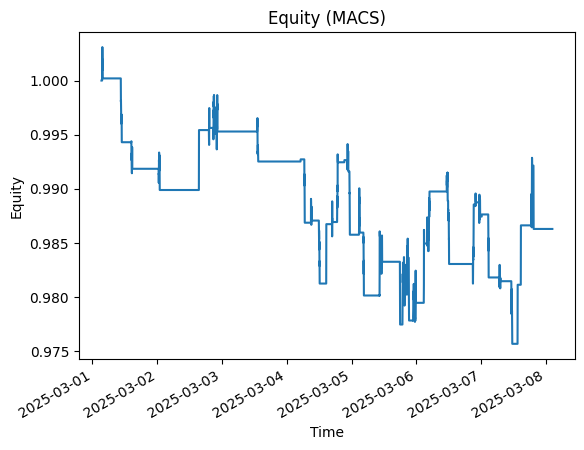

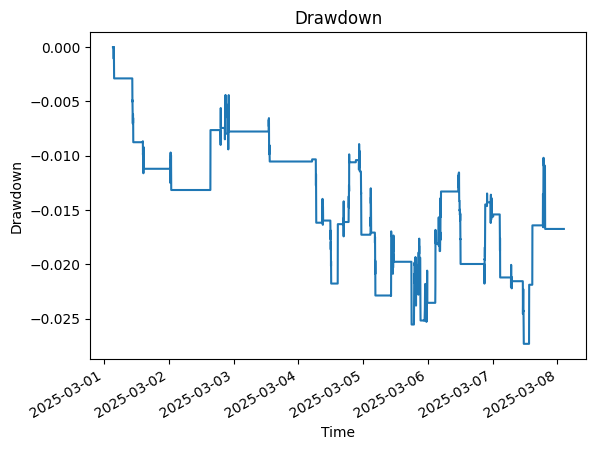

In [34]:
print("MACS:", macs_res_live['stats'], equity_metrics(macs_res_live['equity']))
plot_equity(macs_res_live['equity'], "Equity (MACS)")
plot_drawdown(macs_res_live['equity'])

In [35]:
trades_df = summarize_trades(macs_res_live['trades'])

kpis = trade_kpis(trades_df, threshold=0.0, treat_be_as_win=True)

print(f"Trades: {kpis.get('n_trades', 0)}")
print(f"Win-rate: {kpis.get('win_rate_pct', np.nan):.2f}%")
print(f"Avg win: {kpis.get('avg_win_pct', np.nan):.3f}% | Avg loss: {kpis.get('avg_loss_pct', np.nan):.3f}%")
print(f"Expectancy/trade: {kpis.get('expectancy_pct_per_trade', np.nan):.3f}%")
print(f"Median trade: {kpis.get('median_trade_pct', np.nan):.3f}%")
print(f"Profit factor: {kpis.get('profit_factor', np.nan):.3f}")

if 'by_reason_counts' in kpis:
    print("\nExit reasons (counts):", kpis['by_reason_counts'])
    print("Exit reasons (win-rate %):", kpis['by_reason_winrate_pct'])

Trades: 46
Win-rate: 52.17%
Avg win: 0.280% | Avg loss: -0.367%
Expectancy/trade: -0.029%
Median trade: 0.020%
Profit factor: 0.834

Exit reasons (counts): {'time': 14, 'sl': 11, 'tp': 11, 'be': 10}
Exit reasons (win-rate %): {'be': 100.0, 'sl': 0.0, 'time': 21.428571428571427, 'tp': 100.0}


### Overbought/Oversold

In [33]:
rev_p = ReversalParams(rsi_len=14, rsi_low=30.0, rsi_high=70.0, bb_len=20, bb_k=2,
                          confirm_bullish_candle=True, allow_short=False, enter_on_next_bar=True,
                          exit_on_midband=True)
rev_sig = rsi_boll_reversal_signals(df, rev_p)

# STRICT playback over a short window
logger = TradeLogger(sleep_s=0.15, log_bars=False, log_trades=True)
bt_p = BTParams(
    fee_bps=6, slippage_bps=2,
    tp_pct=0.007, sl_pct=0.0045,
    max_hold_bars=20, cooldown_bars=5, prefer_tp_over_sl=False,
    use_be_trailing=True, be_trigger_frac_of_tp=0.5, be_include_costs=True
)


# pick a shorter slice to watch
start_ts = df.index[0]
end_ts   = df.index[min(10000, len(df)-1)]

rev_res_live = backtest_spot(df, rev_sig, bt_p, strict=True, logger=logger, start=start_ts, end=end_ts)

/var/folders/9q/1x2b1jzn4zl9khtcwg_yx7q40000gn/T/ipykernel_16545/1067079513.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_entry = long_entry.shift(1).fillna(False)
/var/folders/9q/1x2b1jzn4zl9khtcwg_yx7q40000gn/T/ipykernel_16545/1067079513.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_entry = short_entry.shift(1).fillna(False)
/var/folders/9q/1x2b1jzn4zl9khtcwg_yx7q40000gn/T/ipykernel_16545/1067079513.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version

[ENTRY] 2025-03-01 07:40:00+00:00 at 84808.288266 | EQ:1.000000
[EXIT]  2025-03-01 08:00:00+00:00 at 84789.038800 | reason=time | ret=-0.143% | EQ:0.998574
[ENTRY] 2025-03-01 10:58:00+00:00 at 84838.964400 | EQ:0.998574
[EXIT]  2025-03-01 11:18:00+00:00 at 84440.297622 | reason=sl | ret=-0.589% | EQ:0.992689
[ENTRY] 2025-03-02 04:24:00+00:00 at 85597.726122 | EQ:0.992689
[EXIT]  2025-03-02 04:44:00+00:00 at 85770.482472 | reason=time | ret=0.082% | EQ:0.993499
[ENTRY] 2025-03-02 18:38:00+00:00 at 92540.504400 | EQ:0.993499
[EXIT]  2025-03-02 18:39:00+00:00 at 92670.183360 | reason=be | ret=0.020% | EQ:0.993698
[ENTRY] 2025-03-03 18:09:00+00:00 at 89585.273472 | EQ:0.993698
[EXIT]  2025-03-03 18:18:00+00:00 at 89164.303313 | reason=sl | ret=-0.589% | EQ:0.987842
[ENTRY] 2025-03-04 01:43:00+00:00 at 83926.371918 | EQ:0.987842
[EXIT]  2025-03-04 01:44:00+00:00 at 83531.993504 | reason=sl | ret=-0.589% | EQ:0.982020
[ENTRY] 2025-03-04 20:54:00+00:00 at 87344.945496 | EQ:0.982020
[EXIT]  20

Reversal: {'final_capital': np.float64(0.9670648274939031), 'total_return_pct': np.float64(-3.29351725060969), 'n_trades': 15} {'cagr_pct': np.float64(-82.79628855211621), 'max_drawdown_pct': np.float64(-3.964473149796366), 'sharpe': np.float64(-15.322105553695273)}


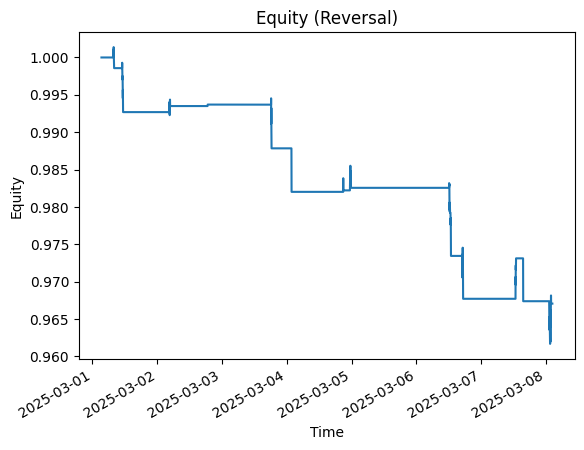

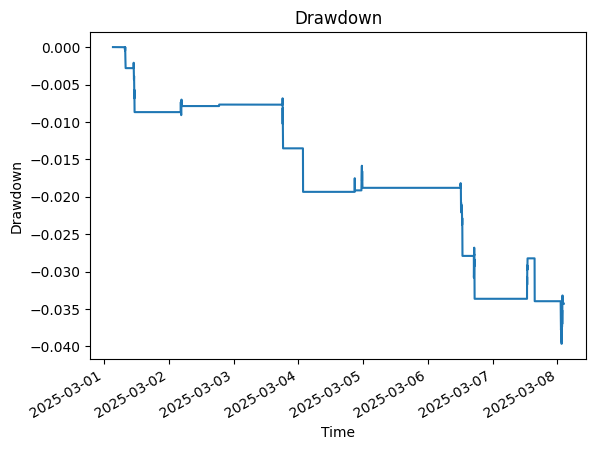

In [34]:
print("Reversal:", rev_res_live['stats'], equity_metrics(rev_res_live['equity']))
plot_equity(rev_res_live['equity'], "Equity (Reversal)")
plot_drawdown(rev_res_live['equity'])

In [35]:
trades_df = summarize_trades(rev_res_live['trades'])

kpis = trade_kpis(trades_df, threshold=0.0, treat_be_as_win=True)

print(f"Trades: {kpis.get('n_trades', 0)}")
print(f"Win-rate: {kpis.get('win_rate_pct', np.nan):.2f}%")
print(f"Avg win: {kpis.get('avg_win_pct', np.nan):.3f}% | Avg loss: {kpis.get('avg_loss_pct', np.nan):.3f}%")
print(f"Expectancy/trade: {kpis.get('expectancy_pct_per_trade', np.nan):.3f}%")
print(f"Median trade: {kpis.get('median_trade_pct', np.nan):.3f}%")
print(f"Profit factor: {kpis.get('profit_factor', np.nan):.3f}")

if 'by_reason_counts' in kpis:
    print("\nExit reasons (counts):", kpis['by_reason_counts'])
    print("Exit reasons (win-rate %):", kpis['by_reason_winrate_pct'])

Trades: 15
Win-rate: 40.00%
Avg win: 0.212% | Avg loss: -0.512%
Expectancy/trade: -0.222%
Median trade: -0.340%
Profit factor: 0.277

Exit reasons (counts): {'sl': 7, 'time': 4, 'be': 2, 'tp': 2}
Exit reasons (win-rate %): {'be': 100.0, 'sl': 0.0, 'time': 50.0, 'tp': 100.0}


### VSBO

In [33]:
vsbo_p = VSBOParams(lookback_high=10, bbw_z_thresh=-1.0, require_trend=True, require_flow=True, require_vol=True)
vsbo_sig = vsbo_signals(df, vsbo_p)

tp_s, sl_s = make_adaptive_tp_sl(df, k_tp=5.0, k_sl=3.5)

logger = TradeLogger(sleep_s=0.15, log_bars=False, log_trades=True)
bt_p = BTParams(
    fee_bps=6, slippage_bps=2,
    max_hold_bars=15,
    tp_pct=0.006, sl_pct=0.0045,
    cooldown_bars=4,
    use_be_trailing=True, be_trigger_frac_of_tp=0.5, be_include_costs=True
)

start_ts = df.index[0]
end_ts   = df.index[min(10000, len(df)-1)]

res_vsbo = backtest_spot(df, vsbo_sig, bt_p,
                         tp_pct_series=tp_s, sl_pct_series=sl_s,
                         strict=True, logger=logger, start=start_ts, end=end_ts)

/var/folders/9q/1x2b1jzn4zl9khtcwg_yx7q40000gn/T/ipykernel_16652/30662685.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_entry = long_entry.shift(1).fillna(False)


[ENTRY] 2025-03-01 16:40:00+00:00 at 85112.259048 | EQ:1.000000
[EXIT]  2025-03-01 16:43:00+00:00 at 84943.431536 | reason=sl | ret=-0.318% | EQ:0.996819
[ENTRY] 2025-03-01 16:55:00+00:00 at 85143.385272 | EQ:0.996819
[EXIT]  2025-03-01 16:59:00+00:00 at 85262.698493 | reason=be | ret=0.020% | EQ:0.997019
[ENTRY] 2025-03-01 17:22:00+00:00 at 85173.031200 | EQ:0.997019
[EXIT]  2025-03-01 17:30:00+00:00 at 84978.401946 | reason=sl | ret=-0.348% | EQ:0.993547
[ENTRY] 2025-03-01 18:54:00+00:00 at 85338.144216 | EQ:0.993547
[EXIT]  2025-03-01 19:09:00+00:00 at 85292.828022 | reason=time | ret=-0.173% | EQ:0.991828
[ENTRY] 2025-03-02 01:54:00+00:00 at 86367.540054 | EQ:0.991828
[EXIT]  2025-03-02 02:07:00+00:00 at 86488.568709 | reason=be | ret=0.020% | EQ:0.992026
[ENTRY] 2025-03-02 22:55:00+00:00 at 94478.881998 | EQ:0.992026
[EXIT]  2025-03-02 22:56:00+00:00 at 94611.277247 | reason=be | ret=0.020% | EQ:0.992225
[ENTRY] 2025-03-03 10:38:00+00:00 at 92387.793864 | EQ:0.992225
[EXIT]  2025-

VSBO: {'final_capital': np.float64(0.9766720860524547), 'total_return_pct': np.float64(-2.33279139475453), 'n_trades': 20} {'cagr_pct': np.float64(-71.07658869010609), 'max_drawdown_pct': np.float64(-2.33279139475453), 'sharpe': np.float64(-16.419707541119003)}


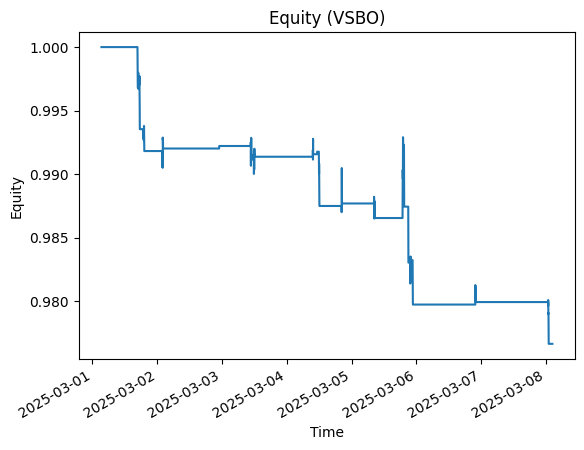

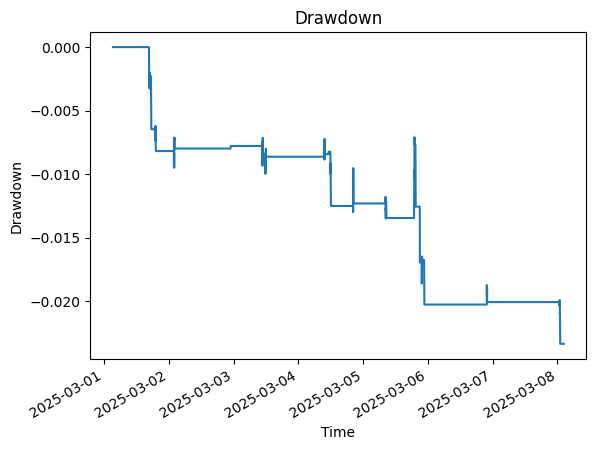

In [34]:
print("VSBO:", res_vsbo['stats'], equity_metrics(res_vsbo['equity']))
plot_equity(res_vsbo['equity'], "Equity (VSBO)")
plot_drawdown(res_vsbo['equity'])

In [35]:
trades_df = summarize_trades(res_vsbo['trades'])

kpis = trade_kpis(trades_df, threshold=0.0, treat_be_as_win=True)

print(f"Trades: {kpis.get('n_trades', 0)}")
print(f"Win-rate: {kpis.get('win_rate_pct', np.nan):.2f}%")
print(f"Avg win: {kpis.get('avg_win_pct', np.nan):.3f}% | Avg loss: {kpis.get('avg_loss_pct', np.nan):.3f}%")
print(f"Expectancy/trade: {kpis.get('expectancy_pct_per_trade', np.nan):.3f}%")
print(f"Median trade: {kpis.get('median_trade_pct', np.nan):.3f}%")
print(f"Profit factor: {kpis.get('profit_factor', np.nan):.3f}")

if 'by_reason_counts' in kpis:
    print("\nExit reasons (counts):", kpis['by_reason_counts'])
    print("Exit reasons (win-rate %):", kpis['by_reason_winrate_pct'])

Trades: 20
Win-rate: 50.00%
Avg win: 0.076% | Avg loss: -0.312%
Expectancy/trade: -0.118%
Median trade: -0.043%
Profit factor: 0.245

Exit reasons (counts): {'be': 9, 'sl': 7, 'time': 3, 'tp': 1}
Exit reasons (win-rate %): {'be': 100.0, 'sl': 0.0, 'time': 0.0, 'tp': 100.0}


### VPUT

In [33]:
vput_p = VPUTParams(z_entry=1.25, require_vol=False)
vput_sig = vput_signals(df, vput_p)

tp_s, sl_s = make_adaptive_tp_sl(df, k_tp=5.0, k_sl=3.5)

logger = TradeLogger(sleep_s=0.15, log_bars=False, log_trades=True)
bt_p = BTParams(
    fee_bps=6, slippage_bps=2,
    max_hold_bars=15,
    tp_pct=0.006, sl_pct=0.0045,
    cooldown_bars=4,
    use_be_trailing=True, be_trigger_frac_of_tp=0.5, be_include_costs=True
)

start_ts = df.index[0]
end_ts   = df.index[min(10000, len(df)-1)]

res_vput = backtest_spot(df, vput_sig, bt_p,
                         tp_pct_series=tp_s, sl_pct_series=sl_s,
                         strict=True, logger=logger, start=start_ts, end=end_ts)

/var/folders/9q/1x2b1jzn4zl9khtcwg_yx7q40000gn/T/ipykernel_16603/2415909103.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_entry = long_entry.shift(1).fillna(False)


[ENTRY] 2025-03-02 00:03:00+00:00 at 86066.729904 | EQ:1.000000
[EXIT]  2025-03-02 00:07:00+00:00 at 86187.337027 | reason=be | ret=0.020% | EQ:1.000200
[ENTRY] 2025-03-02 00:15:00+00:00 at 86043.205200 | EQ:1.000200
[EXIT]  2025-03-02 00:21:00+00:00 at 85878.163424 | reason=sl | ret=-0.312% | EQ:0.997084
[ENTRY] 2025-03-02 00:26:00+00:00 at 85888.124190 | EQ:0.997084
[EXIT]  2025-03-02 00:31:00+00:00 at 86008.481029 | reason=be | ret=0.020% | EQ:0.997283
[ENTRY] 2025-03-02 00:36:00+00:00 at 86129.802516 | EQ:0.997283
[EXIT]  2025-03-02 00:39:00+00:00 at 86250.498024 | reason=be | ret=0.020% | EQ:0.997483
[ENTRY] 2025-03-02 00:45:00+00:00 at 86231.242800 | EQ:0.997483
[EXIT]  2025-03-02 00:55:00+00:00 at 86042.607911 | reason=sl | ret=-0.338% | EQ:0.994107
[ENTRY] 2025-03-02 01:00:00+00:00 at 86043.825324 | EQ:0.994107
[EXIT]  2025-03-02 01:03:00+00:00 at 86164.400350 | reason=be | ret=0.020% | EQ:0.994306
[ENTRY] 2025-03-02 23:57:00+00:00 at 94118.820000 | EQ:0.994306
[EXIT]  2025-03-

VPUT: {'final_capital': np.float64(0.9907238492580375), 'total_return_pct': np.float64(-0.927615074196253), 'n_trades': 9} {'cagr_pct': np.float64(-38.72393656229296), 'max_drawdown_pct': np.float64(-0.9966452421829364), 'sharpe': np.float64(-8.872732456660149)}


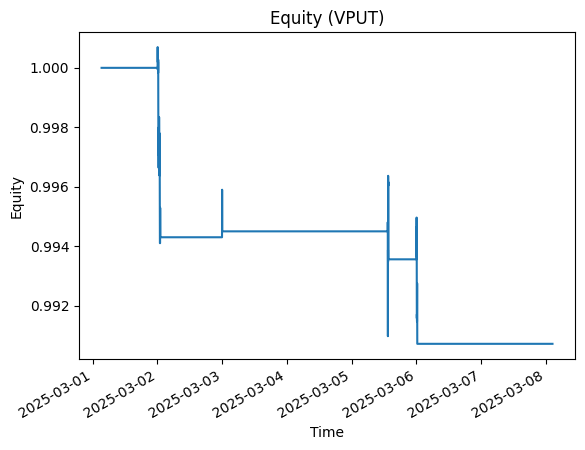

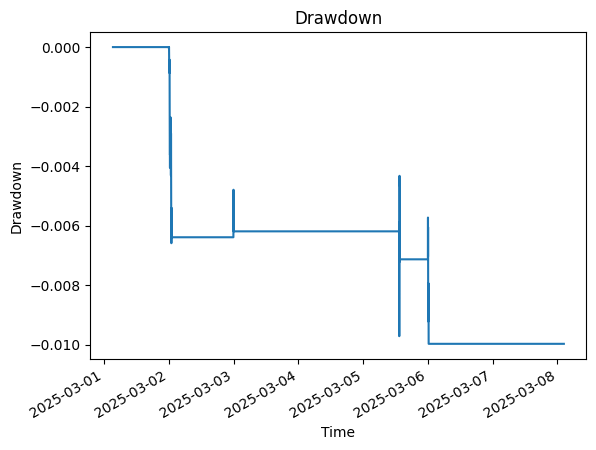

In [34]:
print("VPUT:", res_vput['stats'], equity_metrics(res_vput['equity']))
plot_equity(res_vput['equity'], "Equity (VPUT)")
plot_drawdown(res_vput['equity'])

In [35]:
trades_df = summarize_trades(res_vput['trades'])

kpis = trade_kpis(trades_df, threshold=0.0, treat_be_as_win=True)

print(f"Trades: {kpis.get('n_trades', 0)}")
print(f"Win-rate: {kpis.get('win_rate_pct', np.nan):.2f}%")
print(f"Avg win: {kpis.get('avg_win_pct', np.nan):.3f}% | Avg loss: {kpis.get('avg_loss_pct', np.nan):.3f}%")
print(f"Expectancy/trade: {kpis.get('expectancy_pct_per_trade', np.nan):.3f}%")
print(f"Median trade: {kpis.get('median_trade_pct', np.nan):.3f}%")
print(f"Profit factor: {kpis.get('profit_factor', np.nan):.3f}")

if 'by_reason_counts' in kpis:
    print("\nExit reasons (counts):", kpis['by_reason_counts'])
    print("Exit reasons (win-rate %):", kpis['by_reason_winrate_pct'])

Trades: 9
Win-rate: 55.56%
Avg win: 0.020% | Avg loss: -0.258%
Expectancy/trade: -0.103%
Median trade: 0.020%
Profit factor: 0.097

Exit reasons (counts): {'be': 5, 'sl': 2, 'time': 2}
Exit reasons (win-rate %): {'be': 100.0, 'sl': 0.0, 'time': 0.0}


### OFMB

In [32]:
ofmb_p = OFMBParams(z_ofi=1.0, bbw_z_floor=-0.5, min_vwap_dev_z=-0.75, require_trend=True)
ofmb_sig = ofmb_signals(df, ofmb_p)

tp_s, sl_s = make_adaptive_tp_sl(df, k_tp=5.0, k_sl=3.5)

logger = TradeLogger(sleep_s=0.15, log_bars=False, log_trades=True)
bt_p = BTParams(
    fee_bps=6, slippage_bps=2,
    max_hold_bars=15,
    tp_pct=0.006, sl_pct=0.0045,
    cooldown_bars=4,
    use_be_trailing=True, be_trigger_frac_of_tp=0.5, be_include_costs=True
)

start_ts = df.index[0]
end_ts   = df.index[min(10000, len(df)-1)]

res_ofmb = backtest_spot(df, ofmb_sig, bt_p,
                         tp_pct_series=tp_s, sl_pct_series=sl_s,
                         strict=True, logger=logger, start=start_ts, end=end_ts)

/var/folders/9q/1x2b1jzn4zl9khtcwg_yx7q40000gn/T/ipykernel_16306/1435465639.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_entry = long_entry.shift(1).fillna(False)


[ENTRY] 2025-03-01 10:27:00+00:00 at 85250.766744 | EQ:1.000000
[EXIT]  2025-03-01 10:36:00+00:00 at 85085.577184 | reason=sl | ret=-0.314% | EQ:0.996865
[ENTRY] 2025-03-01 15:10:00+00:00 at 84924.861576 | EQ:0.996865
[EXIT]  2025-03-01 15:15:00+00:00 at 84711.937098 | reason=sl | ret=-0.370% | EQ:0.993173
[ENTRY] 2025-03-01 16:16:00+00:00 at 85071.800958 | EQ:0.993173
[EXIT]  2025-03-01 16:22:00+00:00 at 84911.676300 | reason=sl | ret=-0.308% | EQ:0.990114
[ENTRY] 2025-03-01 16:56:00+00:00 at 85205.687730 | EQ:0.990114
[EXIT]  2025-03-01 17:03:00+00:00 at 85015.057798 | reason=sl | ret=-0.343% | EQ:0.986714
[ENTRY] 2025-03-01 17:17:00+00:00 at 85040.804760 | EQ:0.986714
[EXIT]  2025-03-01 17:21:00+00:00 at 85159.974232 | reason=be | ret=0.020% | EQ:0.986911
[ENTRY] 2025-03-01 17:25:00+00:00 at 85250.076606 | EQ:0.986911
[EXIT]  2025-03-01 17:29:00+00:00 at 85055.755936 | reason=sl | ret=-0.348% | EQ:0.983480
[ENTRY] 2025-03-01 17:53:00+00:00 at 85387.184022 | EQ:0.983480
[EXIT]  2025-

OFMB: {'final_capital': np.float64(0.7479518215904543), 'total_return_pct': np.float64(-25.204817840954576), 'n_trades': 156} {'cagr_pct': np.float64(-99.99997647874217), 'max_drawdown_pct': np.float64(-25.282701274709407), 'sharpe': np.float64(-41.14063563619759)}


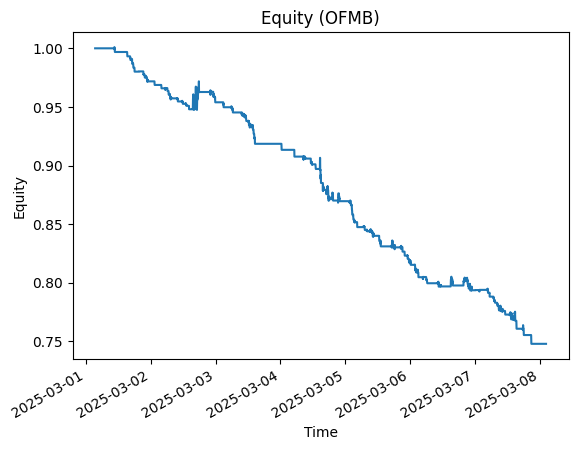

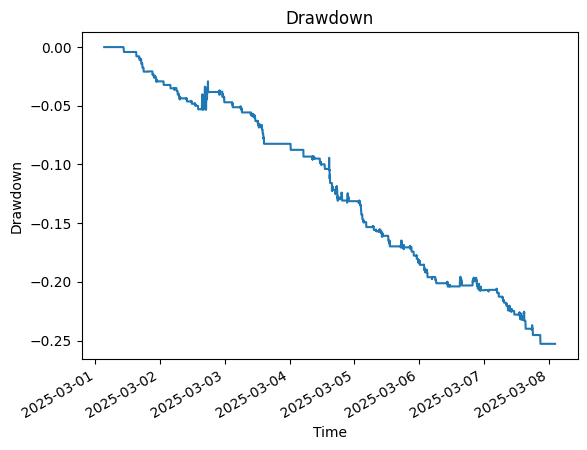

In [34]:
print("OFMB:", res_ofmb['stats'], equity_metrics(res_ofmb['equity']))
plot_equity(res_ofmb['equity'], "Equity (OFMB)")
plot_drawdown(res_ofmb['equity'])

In [36]:
trades_df = summarize_trades(res_ofmb['trades'])

kpis = trade_kpis(trades_df, threshold=0.0, treat_be_as_win=True)

print(f"Trades: {kpis.get('n_trades', 0)}")
print(f"Win-rate: {kpis.get('win_rate_pct', np.nan):.2f}%")
print(f"Avg win: {kpis.get('avg_win_pct', np.nan):.3f}% | Avg loss: {kpis.get('avg_loss_pct', np.nan):.3f}%")
print(f"Expectancy/trade: {kpis.get('expectancy_pct_per_trade', np.nan):.3f}%")
print(f"Median trade: {kpis.get('median_trade_pct', np.nan):.3f}%")
print(f"Profit factor: {kpis.get('profit_factor', np.nan):.3f}")

if 'by_reason_counts' in kpis:
    print("\nExit reasons (counts):", kpis['by_reason_counts'])
    print("Exit reasons (win-rate %):", kpis['by_reason_winrate_pct'])

Trades: 156
Win-rate: 39.74%
Avg win: 0.165% | Avg loss: -0.416%
Expectancy/trade: -0.185%
Median trade: -0.218%
Profit factor: 0.262

Exit reasons (counts): {'sl': 71, 'be': 47, 'time': 26, 'tp': 12}
Exit reasons (win-rate %): {'be': 100.0, 'sl': 0.0, 'time': 11.538461538461538, 'tp': 100.0}
